# PyNeuraLogic Introduction Example

---

This example will showcase how to define a GNN model in the PyNeuraLogic language and evaluate it. The example is self-contained, with everything that is required to be run in a Colab. It can also be run locally if the prerequisites are met (installed Java).

Install PyNeuraLogic from PyPI

In [ ]:
! pip install neuralogic

## Dataset

We are going to use one of the predefined datasets called [Mutagenesis](https://www.doc.ic.ac.uk/~shm/mutagenesis.html). This dataset contains information about molecules that we are going to classify for mutagenicity on Salmonella typhimurium.

Predefined datasets are located in `neuralogic.utils.data`, and by calling `Mutagenesis`, we retrieve a tuple containing the model (rules) and the input data (dataset). For this example, we are going to ignore the model and will define our own.

In [1]:
from neuralogic.utils.data import Mutagenesis


_, dataset = Mutagenesis()

Predefined examples are loaded from the file. We can check the first sample to get an idea how the data look like.

In [2]:
with open(dataset.examples_file) as fp:
    print(fp.readline())

bond(d59_23, d59_5, 0), h(d59_23), c(d59_5), b_1(0), bond(d59_5, d59_23, 0), bond(d59_20, d59_19, 1), c(d59_20), c(d59_19), b_7(1), bond(d59_19, d59_20, 1), bond(d59_10, d59_3, 2), c(d59_10), c(d59_3), b_7(2), bond(d59_3, d59_10, 2), bond(d59_14, d59_10, 3), c(d59_14), b_7(3), bond(d59_10, d59_14, 3), bond(d59_4, d59_3, 4), c(d59_4), b_7(4), bond(d59_3, d59_4, 4), bond(d59_10, d59_9, 5), c(d59_9), b_7(5), bond(d59_9, d59_10, 5), bond(d59_15, d59_28, 6), c(d59_15), h(d59_28), b_1(6), bond(d59_28, d59_15, 6), bond(d59_12, d59_13, 7), c(d59_12), c(d59_13), b_7(7), bond(d59_13, d59_12, 7), bond(d59_8, d59_9, 8), c(d59_8), b_7(8), bond(d59_9, d59_8, 8), bond(d59_7, d59_25, 9), c(d59_7), h(d59_25), b_1(9), bond(d59_25, d59_7, 9), bond(d59_30, d59_17, 10), h(d59_30), c(d59_17), b_1(10), bond(d59_17, d59_30, 10), bond(d59_15, d59_12, 11), b_7(11), bond(d59_12, d59_15, 11), bond(d59_2, d59_1, 12), c(d59_2), c(d59_1), b_7(12), bond(d59_1, d59_2, 12), bond(d59_17, d59_16, 13), c(d59_16), b_7(13),

This textual storage format is slightly different from the PyNeuraLogic language. To encode such samples directly in PyNeuraLogic (Python code), we would write:

```
Relation.bond(Term.d59_23, Term.d59_5, 0), Relation.h(Term.d59_23), ...
```

In this molecular example, we are essentially encoding heterogeneous graphs with edges called `bonds`, where the first two terms are the chemical atom ids, and the third term is the bond id. The atoms' ids are then associated with specific atom types, such as `h` for hydrogen. Bond ids are then associated with bond types, such as `b_1` for a single bond, etc.

## Template

To define the template (model's 'architecture'), we first embed each chemical atom type to `atom_embed` with a unique learnable parameter vector of shape `[3, 1]` (an embedding). This can be simplified by utilizing list comprehension.

In [3]:
from neuralogic.core import Template, R, V


template = Template()

template.add_rules([
    (R.atom_embed(V.A)[3, 1] <= R.get(atom)(V.A)) for atom in ["c", "o", "br", "i", "f", "h", "n", "cl"]
])

In the same way, we encode embeddings for bonds.

In [4]:
template.add_rules([
    (R.bond_embed(V.B)[3, 1] <= R.get(bond)(V.B)) for bond in ["b_1", "b_2", "b_3", "b_4", "b_5", "b_7"]
])

We add one rule ('layer'), which follows the message passing concept of GNNs. Particularly, it aggregates all neighbors `Y` (nodes connected by the bond relation) of the central node `X` and projects representations of `X` and `Y` from the previous layer (`atom_embed`) through learnable parameters of shape `[3, 3]`.  We then combine those projections together with bond embedding. We get a list of values for each neighbor `Y`, which are again combined into one tensor to serve as the output of the relation `layer_1` for node `X`.

In [5]:
template.add_rule(
    R.layer_1(V.X) <= (R.atom_embed(V.X)[3, 3], R.atom_embed(V.Y)[3, 3], R.bond(V.X, V.Y, V.B), R.bond_embed(V.B)),
)

In the same way, we add another two layers that will be 'connected' by utilizing representations from the previous layer. 

In [6]:
template.add_rules([
    R.layer_2(V.X) <= (R.layer_1(V.X)[3, 3], R.layer_1(V.Y)[3, 3], R.bond(V.X, V.Y, V.B), R.bond_embed(V.B)),
    R.layer_3(V.X) <= (R.layer_2(V.X)[3, 3], R.layer_2(V.Y)[3, 3], R.bond(V.X, V.Y, V.B), R.bond_embed(V.B)),
])

In the last layer, we then aggregate all the nodes' (atoms') representations from the previous layer (`layer_3`), combine them, and project them through the learnable parameter of shape `[1, 3]` into a scalar value. This layer is then our output layer, corresponding to the learning target queries.

In [7]:
template.add_rule(
    R.predict[1, 3] <= R.layer_3(V.X),
)

## Training

When we have our dataset and template ready, it's time to build and train the model. We can do the training manually and write our own custom training loop, but we can also use predefined helpers - evaluators, that handle model building, training, dataset building, and more. Evaluators can be customized via `Settings`.

In [8]:
from neuralogic.core import Backend, Settings, Optimizer
from neuralogic.nn.loss import MSE
from neuralogic.nn import get_evaluator


epochs = 120

settings = Settings(optimizer=Optimizer.ADAM, epochs=epochs, learning_rate=0.001, error_function=MSE())
evaluator = get_evaluator(template, Backend.JAVA, settings)

We iterate through the iterator encapsulated in the `train` method for training, which yields a total loss of the epoch and the number of samples of the current epoch. We then get access to the results from the training loop that we can further visualize, inspect, log, etc.

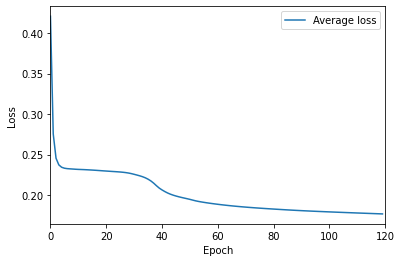

In [9]:
from IPython.display import clear_output
import matplotlib.pyplot as plt


average_losses = []

for current_total_loss, number_of_samples in evaluator.train(dataset):
    clear_output(wait=True)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")

    plt.xlim(0, epochs)

    average_losses.append(current_total_loss / number_of_samples)
    
    plt.plot(average_losses, label="Average loss")

    plt.legend()
    plt.pause(0.001)
    plt.show()

We can also check what values would be the model outputs (for the same sample set here) by utilizing the `test` method.

In [10]:
for y, y_hat in evaluator.test(dataset):
    print(f"Expected: {y}, Predicted: {round(y_hat)} ({y_hat})")

Expected: 1.0, Predicted: 1 (0.7583636965102124)
Expected: 1.0, Predicted: 1 (0.7323460491705178)
Expected: 1.0, Predicted: 0 (0.2993995656765268)
Expected: 1.0, Predicted: 1 (0.6554662345813814)
Expected: 1.0, Predicted: 0 (0.13099011027294097)
Expected: 1.0, Predicted: 1 (0.6804229750848236)
Expected: 1.0, Predicted: 1 (0.6792529178246934)
Expected: 1.0, Predicted: 1 (0.6146868397456817)
Expected: 1.0, Predicted: 1 (0.5252482191581105)
Expected: 1.0, Predicted: 0 (0.34682150586778443)
Expected: 1.0, Predicted: 1 (0.615933840353385)
Expected: 1.0, Predicted: 1 (0.5965356806120112)
Expected: 1.0, Predicted: 1 (0.5387915562815375)
Expected: 1.0, Predicted: 1 (0.5387286959102772)
Expected: 1.0, Predicted: 1 (0.6551983541219301)
Expected: 1.0, Predicted: 1 (0.5084267551621066)
Expected: 1.0, Predicted: 1 (0.7043934398465992)
Expected: 1.0, Predicted: 0 (0.2941796026638397)
Expected: 1.0, Predicted: 1 (0.6347372581925238)
Expected: 1.0, Predicted: 1 (0.6221022010644999)
Expected: 1.0, Pred